In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from scipy.integrate import odeint
from copy import deepcopy
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from sklearn.linear_model import HuberRegressor
from scipy.interpolate import griddata
from scipy.stats import pearsonr
import scipy
%matplotlib inline

# Determine growth rate of oral and gut bacteria

In [2]:
df_oral_taxa = pd.read_csv("../oral_bacteria_identification/bacteria_of_oral_origin.csv")
df_oral_taxa['species_binomial'] = [x.split('_')[0] + '_unclassified' if x.split('_')[1] == 'sp' else ('_').join(x.split('_')[0:2]) for x in df_oral_taxa.species]
df_oral_taxa.head()

,taxon,species,mean_relabun,prevalence,species_binomial
0,k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o...,Fusobacterium_hwasookii,0.104873,36.823105,Fusobacterium_hwasookii
1,k__Bacteria|p__Proteobacteria|c__Betaproteobac...,Eikenella_corrodens,0.106476,54.332130,Eikenella_corrodens
2,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o_...,Prevotella_denticola,0.108301,51.263538,Prevotella_denticola
3,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Stomatobaculum_longum,0.110386,62.093863,Stomatobaculum_longum
4,k__Bacteria|p__Firmicutes|c__Tissierellia|o__T...,Parvimonas_micra,0.111271,72.743682,Parvimonas_micra


In [3]:
df_growth = pd.read_csv("tbl_max_growth.csv")
df_growth = df_growth[df_growth.medium=="AGORA_WD"]
df_growth['species_binomial'] = [x.split('_')[0] + '_unclassified' if x.split('_')[1] == 'sp' else ('_').join(x.split('_')[0:2]) for x in df_growth.agoraid]
df_growth['is_oral'] = ['Yes' if x in list(df_oral_taxa.species_binomial) else 'No' for x in df_growth.species_binomial]
df_growth.head()

,agoraid,max_growth_rate,medium,species_binomial,is_oral
4908,Abiotrophia_defectiva_ATCC_49176,0.229485,AGORA_WD,Abiotrophia_defectiva,No
4909,Achromobacter_xylosoxidans_A8,0.402918,AGORA_WD,Achromobacter_xylosoxidans,No
4910,Achromobacter_xylosoxidans_NBRC_15126,0.217327,AGORA_WD,Achromobacter_xylosoxidans,No
4911,Acidaminococcus_fermentans_DSM_20731,0.200883,AGORA_WD,Acidaminococcus_fermentans,No
4912,Acidaminococcus_intestini_RyC_MR95,0.066094,AGORA_WD,Acidaminococcus_intestini,No


In [4]:
df_growth.groupby('is_oral')['max_growth_rate'].agg(np.mean)

is_oral
No     0.353399
Yes    0.236145
Name: max_growth_rate, dtype: float64

In [5]:
len(df_growth[df_growth.is_oral=='Yes']),len(df_growth[df_growth.is_oral=='No'])

(84, 734)

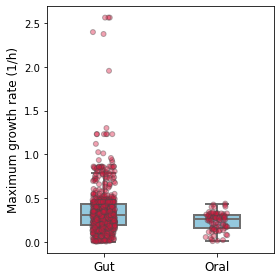

In [6]:
fig, ax = plt.subplots(figsize=(4,4))

_ = sns.boxplot(x="is_oral", y="max_growth_rate", data=df_growth, ax=ax,
                width=0.4, color="skyblue", linewidth=2, showfliers=False
               )
_ = sns.stripplot(x="is_oral", y="max_growth_rate", data=df_growth, ax=ax,
                  color="crimson", linewidth=1, alpha=0.4
                 )
_ = ax.set_xticklabels(['Gut','Oral'], fontsize=12)
_ = ax.set_xlabel('')
_ = ax.set_ylabel('Maximum growth rate (1/h)', fontsize=12)

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("gut_oral_bact_growth_rate.svg", dpi=600, bbox_inches='tight')

# Parameters

In [67]:
alpha_o = 3.10e6 # oral-gut transmission rate
K_o = 1.39e9 # carrying capacity of oral bacteria, cfu/g
K_g = 2.92e10 # carrying capacity of gut bacteria, cfu/g
gamma_o = 0.24 # maximum growth rate of oral bacteria, 1/h
gamma_g = 0.35 # maximum growht rate of gut bacteria, 1/h
D = 0.08 # fecal excretion rate, 1/h

# Model

In [68]:
def glv(y, t, eps_o, eps_g, tstop):
    B_o, B_g = y
    if t <= tstop:
        epsilon_o_prime = eps_o
        epsilon_g_prime = eps_g
    else:
        epsilon_o_prime = 1
        epsilon_g_prime = 1
    dydt = [
        alpha_o + gamma_o * (1-B_o/K_o-B_g/K_g) * B_o * epsilon_o_prime - D*B_o,
                  gamma_g * (1-B_o/K_o-B_g/K_g) * B_g * epsilon_g_prime - D*B_g
    ]
    return dydt

# Simulation: plot all trajectories

In [69]:
epsilon_o = 10**(np.linspace(-2,0,41))
epsilon_g = 10**(np.linspace(-2,0,41))
tend = 2000 # simulation time

In [70]:
# get steady state before any perturbation
sol = odeint(glv, [0.1,0.1], np.linspace(0,tend,100), args=(1,1,tend))
steady_state = list(sol[-1])

# add perturbations
df = None
for eps_o in epsilon_o:
    for eps_g in epsilon_g:
        tspan = np.linspace(0, tend, int(tend/5)+1)
        sol = odeint(glv, steady_state, tspan, args=(eps_o, eps_g, tend))
        df2 = pd.DataFrame(sol, index=tspan, columns=['B_o','B_g'])
        df2['Loadt'] = df2['B_o']+df2['B_g']
        df2['Oralf'] = df2['B_o']/df2['Loadt']
        df2['Epsilon_o'] = eps_o
        df2['Epsilon_g'] = eps_g
        df2['log10_Epsilon_o'] = np.log10(eps_o)
        df2['log10_Epsilon_g'] = np.log10(eps_g)
        df2['Epsilon_ratio'] = eps_o/eps_g
        df2['log10_Epsilon_ratio'] = np.log10(eps_o/eps_g)
        if df is None:
            df = deepcopy(df2)
        else:
            df = pd.concat([df,df2])
df.index.name='Time'
df = df.reset_index()
df.head()

,Time,B_o,B_g,Loadt,Oralf,Epsilon_o,Epsilon_g,log10_Epsilon_o,log10_Epsilon_g,Epsilon_ratio,log10_Epsilon_ratio
0,0.0,1.232955e+08,1.993562e+10,2.005892e+10,0.006147,0.01,0.01,-2.0,-2.0,1.0,0.0
1,5.0,9.580674e+07,1.344716e+10,1.354297e+10,0.007074,0.01,0.01,-2.0,-2.0,1.0,0.0
2,10.0,7.746889e+07,9.102180e+09,9.179649e+09,0.008439,0.01,0.01,-2.0,-2.0,1.0,0.0
3,15.0,6.518715e+07,6.175564e+09,6.240751e+09,0.010445,0.01,0.01,-2.0,-2.0,1.0,0.0
4,20.0,5.693970e+07,4.196560e+09,4.253500e+09,0.013387,0.01,0.01,-2.0,-2.0,1.0,0.0


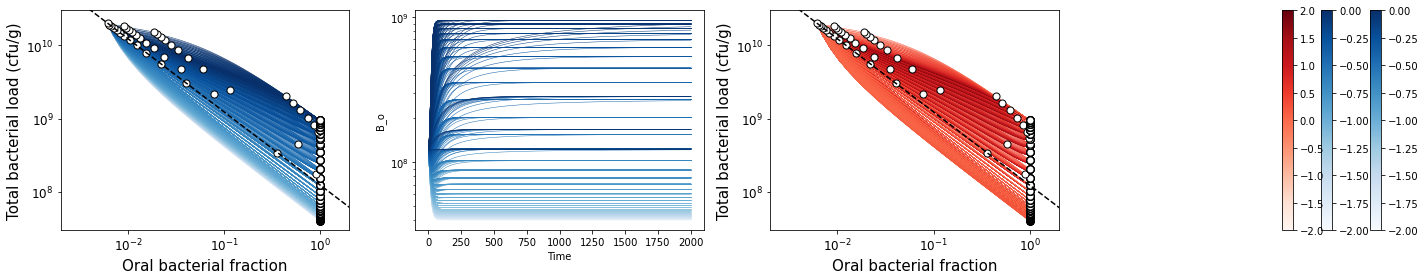

In [72]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,4))

for k,hue in enumerate(['log10_Epsilon_o','log10_Epsilon_o','log10_Epsilon_ratio']):
    if k==0 or k==1:
        palette='Blues'
        norm = plt.Normalize(-2,0)
    else:
        palette='Reds'
        norm = plt.Normalize(-2,2)
    sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
    sm.set_array([])
    for eps_o in epsilon_o:
        for eps_g in epsilon_g:
            if eps_o >= eps_g:
                curr_df = df[(df.Epsilon_o==eps_o) & (df.Epsilon_g==eps_g)]
                _ = ax[k]
                if k==0:
                    _ = sns.lineplot(x='Oralf', y='Loadt', hue=hue, data=curr_df, ax=ax[k], palette=palette, hue_norm=(-2,0), zorder=-10, linewidth=0.5)
                elif k==1:
                    _ = sns.lineplot(x='Time', y='B_o', hue=hue, data=curr_df, ax=ax[k], palette=palette, hue_norm=(-2,0), zorder=-10, linewidth=0.5)
                else:
                    _ = sns.lineplot(x='Oralf', y='Loadt', hue=hue, data=curr_df, ax=ax[k], palette=palette, hue_norm=(-2,2), zorder=-10, linewidth=0.5)
                
                if k==0 or k==2:
                    xfinal = curr_df.iloc[-1].Oralf
                    yfinal = curr_df.iloc[-1].Loadt
                    _ = ax[k].scatter(xfinal, yfinal, s=50, facecolors='white', edgecolors='black')
                
                if ax[k].get_legend() is not None:
                    _ = ax[k].get_legend().remove()

    if k==0 or k==2:
        _ = ax[k].set_xscale('log')
        _ = ax[k].set_yscale('log')
        _ = ax[k].minorticks_off()
        _ = ax[k].tick_params(axis='both', which='major', labelsize=12)
        _ = ax[k].set_xlabel('Oral bacterial fraction', fontsize=15)
        _ = ax[k].set_ylabel('Total bacterial load (cfu/g)', fontsize=15)
        _ = ax[k].plot([1e-3,10],[steady_state[0]/1e-3, steady_state[0]/10], 'k--')
        _ = ax[k].set_xlim([2e-3,2])
        _ = ax[k].set_ylim([3e7,3e10])
    else:
        _ = ax[k].set_yscale('log')
    
    _ = ax[3].figure.colorbar(sm)
    
_ = ax[3].axis('off')

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("bacteriostatic_trajs_until_ss_log.svg", dpi=600, bbox_inches='tight')

## get triangle slope

In [15]:
# lower bound
(np.log(np.sum(steady_state))-np.log(alpha_o/D))/(np.log(steady_state[0]/np.sum(steady_state)))

-1.2273149821661835

In [16]:
# upper bound
(np.log(np.sum(steady_state))-np.log((K_o*(gamma_o-D)+np.sqrt(K_o**2*(D-gamma_o)**2+4*alpha_o*gamma_o*K_o))/2/gamma_o))/(np.log(steady_state[0]/np.sum(steady_state)))

-0.5998912833598837

# Plot heatmap of slope and correlation

## log scale

In [17]:
epsilon_o = 10**(np.linspace(-2,0,41))
epsilon_g = 10**(np.linspace(-2,0,41))
tend = 2000 # simulation time

In [18]:
# get steady state before any perturbation
sol = odeint(glv, [0.1,0.1], np.linspace(0,tend,100), args=(1,1,tend))
steady_state = list(sol[-1])

# add perturbations
df = None
for eps_o in epsilon_o:
    for eps_g in epsilon_g:
        tspan = np.linspace(0, tend, int(tend/5)+1)
        sol = odeint(glv, steady_state, tspan, args=(eps_o, eps_g, tend))
        df2 = pd.DataFrame(sol, index=tspan, columns=['B_o','B_g'])
        df2['Loadt'] = df2['B_o']+df2['B_g']
        df2['Oralf'] = df2['B_o']/df2['Loadt']
        df2['Epsilon_o'] = eps_o
        df2['Epsilon_g'] = eps_g
        df2['log10_Epsilon_o'] = np.log10(eps_o)
        df2['log10_Epsilon_g'] = np.log10(eps_g)
        df2['Epsilon_ratio'] = eps_o/eps_g
        df2['log10_Epsilon_ratio'] = np.log10(eps_o/eps_g)
        if df is None:
            df = deepcopy(df2)
        else:
            df = pd.concat([df,df2])
df.index.name='Time'
df = df.reset_index()
df.head()

,Time,B_o,B_g,Loadt,Oralf,Epsilon_o,Epsilon_g,log10_Epsilon_o,log10_Epsilon_g,Epsilon_ratio,log10_Epsilon_ratio
0,0.0,1.232955e+08,1.993562e+10,2.005892e+10,0.006147,0.01,0.01,-2.0,-2.0,1.0,0.0
1,5.0,9.580674e+07,1.344716e+10,1.354297e+10,0.007074,0.01,0.01,-2.0,-2.0,1.0,0.0
2,10.0,7.746889e+07,9.102180e+09,9.179649e+09,0.008439,0.01,0.01,-2.0,-2.0,1.0,0.0
3,15.0,6.518715e+07,6.175564e+09,6.240751e+09,0.010445,0.01,0.01,-2.0,-2.0,1.0,0.0
4,20.0,5.693970e+07,4.196560e+09,4.253500e+09,0.013387,0.01,0.01,-2.0,-2.0,1.0,0.0


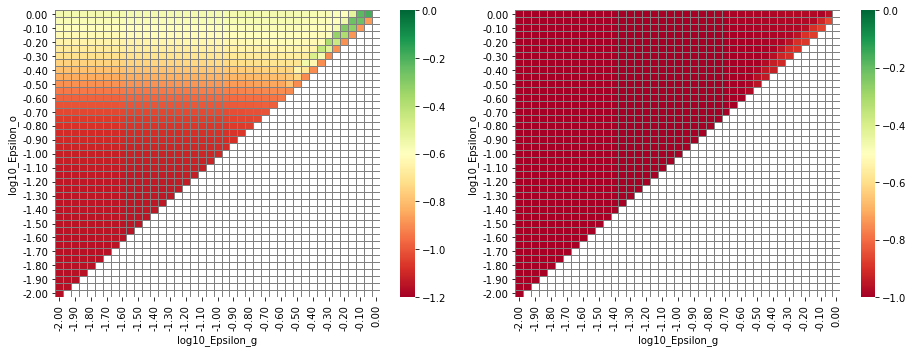

In [19]:
# plot slope
slope = []
for eps_o in epsilon_o:
    for eps_g in epsilon_g:
        if eps_o >= eps_g:
            if eps_o == eps_g and eps_o == 1.0:
                # trajectory will stay at steady state
                continue
            else:
                # cannot do interpolation if we include oral fraction = 1
                curr_df = df.loc[(df.Epsilon_o==eps_o) & (df.Epsilon_g==eps_g), ['Oralf','Loadt']].drop_duplicates()
                curr_df['Oralf'] = curr_df['Oralf'].apply(lambda x: format(float(x),".6f")).astype(float)
                curr_df = curr_df.drop_duplicates(subset=['Oralf'])
                if len(curr_df) <= 10:
                    xnew = list(np.log10(curr_df.Oralf))
                    ynew = list(np.log10(curr_df.Loadt))
                else:
                    f2 = interp1d(np.log10(curr_df.Oralf), np.log10(curr_df.Loadt), kind='linear')
                    xnew = np.linspace(np.log10(curr_df.Oralf.min()), np.log10(curr_df.Oralf.max()), 10)
                    ynew = f2(xnew)
                rng=np.random.RandomState(42)
                #huber = HuberRegressor().fit(np.array(xnew).reshape(-1,1), np.array(ynew))
                fit = scipy.stats.linregress(xnew, ynew)
                psr = pearsonr(xnew, ynew)
                #slope.append([eps_o, eps_g, huber.coef_[0], psr[0]])
                slope.append([eps_o, eps_g, fit.slope, psr[0]])
            
df2plot = pd.DataFrame(slope, columns=['Epsilon_o','Epsilon_g','Slope','Correlation'])
df2plot = df2plot.sort_values(['Epsilon_o','Epsilon_g'])
df2plot['log10_Epsilon_o'] = np.log10(df2plot.Epsilon_o).apply(lambda x: format(float(x),".2f"))
df2plot['log10_Epsilon_g'] = np.log10(df2plot.Epsilon_g).apply(lambda x: format(float(x),".2f"))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13,5))

# slope
df_slope = pd.pivot_table(df2plot, index='log10_Epsilon_o', columns='log10_Epsilon_g', values='Slope')
df_slope.loc["0.00","0.00"] = np.NaN
index = [str("%2.2f" % x) for x in np.log10(epsilon_o)]
df_slope = df_slope.loc[index[::-1], index]
x = list(df2plot.log10_Epsilon_o)
y = list(df2plot.log10_Epsilon_g)
vals = list(df2plot.Slope)
X, Y = np.meshgrid(epsilon_o, epsilon_g)

interpolated_vals = griddata((x, y), vals, (X, Y), method='cubic')
#_ = ax[0].contourf(X, Y, interpolated_vals, cmap='RdYlGn', vmin=-1.1, vmax=0.1)
_ = sns.heatmap(df_slope, ax=ax[0], cmap="RdYlGn", vmin=-1.2, vmax=0, linewidth=0.5, linecolor='gray') 
#for x,y in zip([-0.8,-0.55,-0.3],[-1.0,-1.0,-1.0]):
#    _ = ax[0].scatter(x,y,s=100,marker='x',color='k')

# pearson correlation
df_corr = pd.pivot_table(df2plot, index='log10_Epsilon_o', columns='log10_Epsilon_g', values='Correlation')
df_corr.loc["0.00","0.00"] = np.NaN
index = [str("%2.2f" % x) for x in np.log10(epsilon_o)]
df_corr = df_corr.loc[index[::-1], index]
x = list(df2plot.log10_Epsilon_o)
y = list(df2plot.log10_Epsilon_g)
vals = list(df2plot.Correlation)
X, Y = np.meshgrid(epsilon_o, epsilon_g)

interpolated_vals = griddata((x, y), vals, (X, Y), method='cubic')
#_ = ax[1].contourf(X, Y, interpolated_vals, cmap='RdYlGn', vmin=-1, vmax=0)
_ = sns.heatmap(df_corr, ax=ax[1], cmap="RdYlGn", vmin=-1, vmax=0, linewidth=0.5, linecolor='gray') 
#for x,y in zip([-0.8,-0.55,-0.3],[-1.0,-1.0,-1.0]):
#    _ = ax[1].scatter(x,y,s=100,marker='x',color='k')
    
plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("bacteriostatic_heatmap_slope_pearsoncorr_log.svg", dpi=600, bbox_inches='tight')

In [20]:
# min and max of slope
[df_slope.min().min(), df_slope.max().max()]

[-1.1596618317189824, -0.1917463589154525]

In [21]:
# min and max of correlation
[df_corr.min().min(), df_corr.max().max()]

[-0.9988792133262343, -0.8590909371004691]

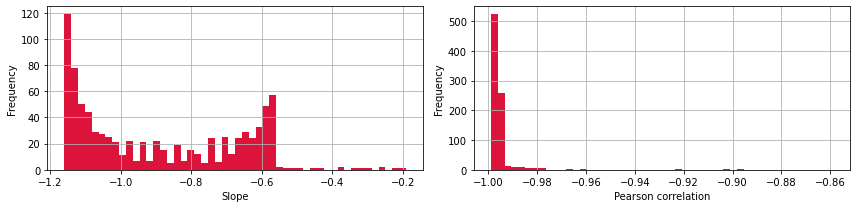

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

_ = df_slope.stack().reset_index()[0].hist(bins=50, ax=ax[0], color='#DC143C')
_ = ax[0].set_xlabel('Slope')
_ = ax[0].set_ylabel('Frequency')
_ = df_corr.stack().reset_index()[0].hist(bins=50, ax=ax[1], color='#DC143C')
_ = ax[1].set_xlabel('Pearson correlation')
_ = ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("bacteriostatic_hist_slope_pearsoncorr_log.svg", dpi=600, bbox_inches='tight')

## linear scale

In [23]:
epsilon_o = np.linspace(0,1,41)
epsilon_g = np.linspace(0,1,41)
tend = 2000 # simulation time

In [24]:
# get steady state before any perturbation
sol = odeint(glv, [0.1,0.1], np.linspace(0,tend,100), args=(1,1,tend))
steady_state = list(sol[-1])

# add perturbations
df = None
for eps_o in epsilon_o:
    for eps_g in epsilon_g:
        tspan = np.linspace(0, tend, int(tend/5)+1)
        sol = odeint(glv, steady_state, tspan, args=(eps_o, eps_g, tend))
        df2 = pd.DataFrame(sol, index=tspan, columns=['B_o','B_g'])
        df2['Loadt'] = df2['B_o']+df2['B_g']
        df2['Oralf'] = df2['B_o']/df2['Loadt']
        df2['Epsilon_o'] = eps_o
        df2['Epsilon_g'] = eps_g
        df2['Epsilon_ratio'] = eps_o/eps_g
        if df is None:
            df = deepcopy(df2)
        else:
            df = pd.concat([df,df2])
df.index.name='Time'
df = df.reset_index()
df.head()

<ipython-input-24-3a63dac96144>:16: RuntimeWarning: invalid value encountered in double_scalars
  df2['Epsilon_ratio'] = eps_o/eps_g
<ipython-input-24-3a63dac96144>:16: RuntimeWarning: divide by zero encountered in double_scalars
  df2['Epsilon_ratio'] = eps_o/eps_g


,Time,B_o,B_g,Loadt,Oralf,Epsilon_o,Epsilon_g,Epsilon_ratio
0,0.0,1.232955e+08,1.993562e+10,2.005892e+10,0.006147,0.0,0.0,NaN
1,5.0,9.542251e+07,1.336325e+10,1.345867e+10,0.007090,0.0,0.0,NaN
2,10.0,7.673872e+07,8.957653e+09,9.034392e+09,0.008494,0.0,0.0,NaN
3,15.0,6.421460e+07,6.004494e+09,6.068709e+09,0.010581,0.0,0.0,NaN
4,20.0,5.581943e+07,4.024933e+09,4.080752e+09,0.013679,0.0,0.0,NaN


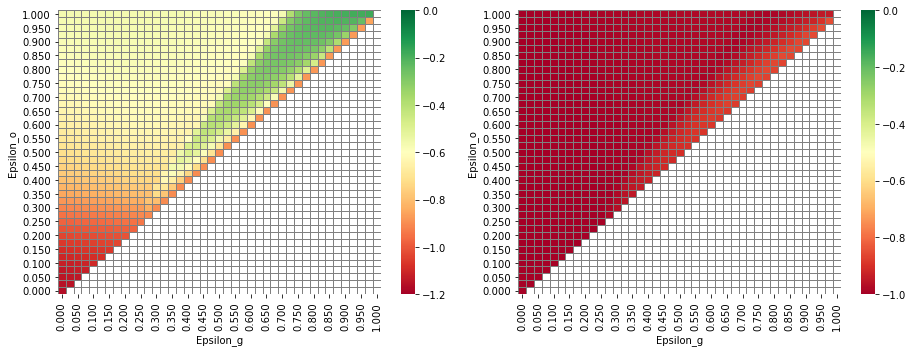

In [25]:
# plot slope
slope = []
for eps_o in epsilon_o:
    for eps_g in epsilon_g:
        if eps_o >= eps_g:
            if eps_o == eps_g and eps_o == 1.0:
                # trajectory will stay at steady state
                continue
            else:
                # cannot do interpolation if we include oral fraction = 1
                curr_df = df.loc[(df.Epsilon_o==eps_o) & (df.Epsilon_g==eps_g), ['Oralf','Loadt']]
                curr_df['Oralf'] = curr_df['Oralf'].apply(lambda x: format(float(x),".6f")).astype(float)
                curr_df = curr_df.drop_duplicates(subset=['Oralf'])
                if len(curr_df) <= 10:
                    xnew = list(np.log10(curr_df.Oralf))
                    ynew = list(np.log10(curr_df.Loadt))
                else:
                    f2 = interp1d(np.log10(curr_df.Oralf), np.log10(curr_df.Loadt), kind='linear')
                    xnew = np.linspace(np.log10(curr_df.Oralf.min()), np.log10(curr_df.Oralf.max()), 10)
                    ynew = f2(xnew)
                rng=np.random.RandomState(42)
                #huber = HuberRegressor().fit(np.array(xnew).reshape(-1,1), np.array(ynew))
                fit = scipy.stats.linregress(xnew, ynew)
                psr = pearsonr(xnew, ynew)
                #slope.append([eps_o, eps_g, huber.coef_[0], psr[0]])
                slope.append([eps_o, eps_g, fit.slope, psr[0]])
            
df2plot = pd.DataFrame(slope, columns=['Epsilon_o','Epsilon_g','Slope','Correlation'])
df2plot = df2plot.sort_values(['Epsilon_o','Epsilon_g'])
df2plot['Epsilon_o'] = df2plot.Epsilon_o.apply(lambda x: format(float(x),"2.3f"))
df2plot['Epsilon_g'] = df2plot.Epsilon_g.apply(lambda x: format(float(x),"2.3f"))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13,5))

# slope
df_slope = pd.pivot_table(df2plot, index='Epsilon_o', columns='Epsilon_g', values='Slope')
df_slope['1.000'] = np.NaN
index = [str("%2.3f" % x) for x in epsilon_o]
df_slope = df_slope.loc[index[::-1], index]
x = list(df2plot.Epsilon_o)
y = list(df2plot.Epsilon_g)
vals = list(df2plot.Slope)
X, Y = np.meshgrid(epsilon_o, epsilon_g)

interpolated_vals = griddata((x, y), vals, (X, Y), method='cubic')
#_ = ax[0].contourf(X, Y, interpolated_vals, cmap='RdYlGn', vmin=-1.1, vmax=0.1)
_ = sns.heatmap(df_slope, ax=ax[0], cmap="RdYlGn", vmin=-1.2, vmax=0, linewidth=0.5, linecolor='gray') 
#for x,y in zip([-0.8,-0.55,-0.3],[-1.0,-1.0,-1.0]):
#    _ = ax[0].scatter(x,y,s=100,marker='x',color='k')

# pearson correlation
df_corr = pd.pivot_table(df2plot, index='Epsilon_o', columns='Epsilon_g', values='Correlation')
df_corr['1.000'] = np.NaN
index = [str("%2.3f" % x) for x in epsilon_o]
df_corr = df_corr.loc[index[::-1], index]
x = list(df2plot.Epsilon_o)
y = list(df2plot.Epsilon_g)
vals = list(df2plot.Correlation)
X, Y = np.meshgrid(epsilon_o, epsilon_g)

interpolated_vals = griddata((x, y), vals, (X, Y), method='cubic')
#_ = ax[1].contourf(X, Y, interpolated_vals, cmap='RdYlGn', vmin=-1, vmax=0)
_ = sns.heatmap(df_corr, ax=ax[1], cmap="RdYlGn", vmin=-1, vmax=0, linewidth=0.5, linecolor='gray') 
#for x,y in zip([-0.8,-0.55,-0.3],[-1.0,-1.0,-1.0]):
#    _ = ax[1].scatter(x,y,s=100,marker='x',color='k')
    
plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("bacteriostatic_heatmap_slope_pearsoncorr_linear.svg", dpi=600, bbox_inches='tight')

In [26]:
# min and max of slope
[df_slope.min().min(), df_slope.max().max()]

[-1.1650722768283879, -0.1827320859565823]

In [27]:
# min and max of correlation
[df_corr.min().min(), df_corr.max().max()]

[-0.9989002535111111, -0.8504990760054298]

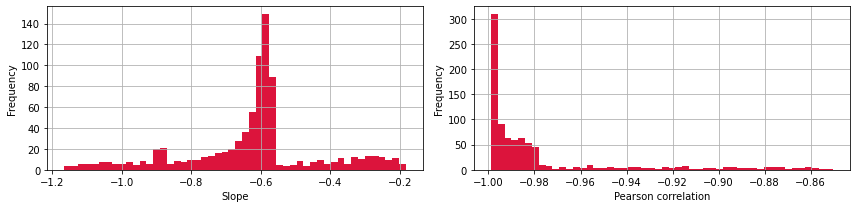

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

_ = df_slope.stack().reset_index()[0].hist(bins=50, ax=ax[0], color='#DC143C')
_ = ax[0].set_xlabel('Slope')
_ = ax[0].set_ylabel('Frequency')
_ = df_corr.stack().reset_index()[0].hist(bins=50, ax=ax[1], color='#DC143C')
_ = ax[1].set_xlabel('Pearson correlation')
_ = ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("bacteriostatic_hist_slope_pearsoncorr_linear.svg", dpi=600, bbox_inches='tight')

# Simulation plot specific trajectories

In [53]:
epsilon_o=[0.10,0.23,0.70]
epsilon_g=[0.05,0.05,0.05]
tend = 2000 # simulation time

In [54]:
# get steady state before any perturbation
sol = odeint(glv, [0.1,0.1], np.linspace(0,tend,100), args=(1,1,tend))
steady_state = list(sol[-1])

# add perturbations
df = None
for eps_o, eps_g in zip(epsilon_o, epsilon_g):
    tspan = np.linspace(0, tend, int(tend/5)+1)
    sol = odeint(glv, steady_state, tspan, args=(eps_o, eps_g, tend))
    df2 = pd.DataFrame(sol, index=tspan, columns=['B_o','B_g'])
    df2['Loadt'] = df2['B_o']+df2['B_g']
    df2['Oralf'] = df2['B_o']/df2['Loadt']
    df2['log10_Loadt'] = np.log10(df2.Loadt)
    df2['log10_Oralf'] = np.log10(df2.Oralf)
    df2['Epsilon_o'] = eps_o
    df2['Epsilon_g'] = eps_g
    df2['log10_Epsilon_o'] = np.log10(eps_o)
    df2['log10_Epsilon_g'] = np.log10(eps_g)
    df2['Epsilon_ratio'] = eps_o/eps_g
    df2['log10_Epsilon_ratio'] = np.log10(eps_o/eps_g)
    if df is None:
        df = deepcopy(df2)
    else:
        df = pd.concat([df,df2])
df.index.name='Time'
df = df.reset_index()
df.head()

,Time,B_o,B_g,Loadt,Oralf,log10_Loadt,log10_Oralf,Epsilon_o,Epsilon_g,log10_Epsilon_o,log10_Epsilon_g,Epsilon_ratio,log10_Epsilon_ratio
0,0.0,1.232955e+08,1.993562e+10,2.005892e+10,0.006147,10.302308,-2.211360,0.1,0.05,-1.0,-1.30103,2.0,0.30103
1,5.0,9.925921e+07,1.377972e+10,1.387898e+10,0.007152,10.142358,-2.145587,0.1,0.05,-1.0,-1.30103,2.0,0.30103
2,10.0,8.415370e+07,9.681410e+09,9.765563e+09,0.008617,9.989697,-2.064624,0.1,0.05,-1.0,-1.30103,2.0,0.30103
3,15.0,7.435380e+07,6.877039e+09,6.951393e+09,0.010696,9.842072,-1.970769,0.1,0.05,-1.0,-1.30103,2.0,0.30103
4,20.0,6.786388e+07,4.922022e+09,4.989886e+09,0.013600,9.698091,-1.866452,0.1,0.05,-1.0,-1.30103,2.0,0.30103


In [55]:
def glv_given_Bg(y, t, eps_o, interp, tstop, opt):
    B_o = y
    if opt=='abx_only':
        B_g = interp(0)
    elif opt=='competition_only':
        if t>np.max(interp.x):
            B_g = interp(np.max(interp.x))
        else:
            B_g = interp(t)
    if t <= tstop:
        epsilon_o_prime = eps_o
    else:
        epsilon_o_prime = 1
    if opt=='abx_only':
        dydt = alpha_o + gamma_o * (1-B_o/K_o-B_g/K_g) * B_o * epsilon_o_prime - D*B_o
    elif opt=='competition_only':
        dydt = alpha_o + gamma_o * (1-B_o/K_o-B_g/K_g) * B_o - D*B_o
        
    return dydt

<ipython-input-56-874e0c97b637>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_df['Oralf'] = curr_df['Oralf'].apply(lambda x: format(float(x),".6f")).astype(float)
<ipython-input-56-874e0c97b637>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_df['Oralf'] = curr_df['Oralf'].apply(lambda x: format(float(x),".6f")).astype(float)
<ipython-input-56-874e0c97b637>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

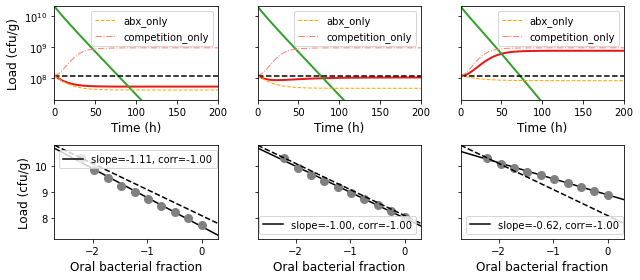

In [56]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(9,4), sharey='row')

my_colors = sns.color_palette("Paired")
for k,eps_o in enumerate(epsilon_o):
    # plot B_o
    curr_df = df[(df.Epsilon_o == eps_o) & (df.Time<=200)]
    _ = ax[0,k].plot(curr_df.Time, curr_df.B_o, '-', color=my_colors[5], linewidth=2)
    _ = ax[0,k].plot(curr_df.Time, curr_df.B_g, '-', color=my_colors[3], linewidth=2)
    _ = ax[0,k].plot(curr_df.Time, [steady_state[0]]*len(curr_df), 'k--')
    
    # plot perturbed trajectories with different mechanisms
    tend = 200
    tspan = np.linspace(0, tend, int(tend/5)+1)
    interp = interp1d(curr_df.Time, curr_df.B_g)
    sol1 = odeint(glv_given_Bg, steady_state[0], tspan, args=(eps_o, interp, tend, 'abx_only'))
    sol2 = odeint(glv_given_Bg, steady_state[0], tspan, args=(eps_o, interp, tend, 'competition_only'))
    df_sol1 = pd.DataFrame(sol1, index=tspan, columns=['B_o'])
    df_sol2 = pd.DataFrame(sol2, index=tspan, columns=['B_o'])
    _ = ax[0,k].plot(df_sol1.index, df_sol1.B_o, '--', color='orange', linewidth=1, label='abx_only')
    _ = ax[0,k].plot(df_sol2.index, df_sol2.B_o, '-.', color='salmon', linewidth=1, label='competition_only')
    _ = ax[0,k].set_yscale('log')
    _ = ax[0,k].set_ylim([2e7, 2e10])
    _ = ax[0,k].set_xlim([0,200])
    _ = ax[0,k].set_yticks([1e8,1e9,1e10])
    _ = ax[0,k].set_xlabel('Time (h)', fontsize=12)
    if k==0:
        _ = ax[0,k].set_ylabel('Load (cfu/g)', fontsize=12)
    else:
        _ = ax[0,k].set_ylabel('')
    _ = ax[0,k].legend()
    _ = ax[0,k].minorticks_off()
    
    # compute slope and correlation
    curr_df = df.loc[df.Epsilon_o==eps_o]
    curr_df['Oralf'] = curr_df['Oralf'].apply(lambda x: format(float(x),".6f")).astype(float)
    curr_df = curr_df.drop_duplicates(subset=['Oralf'])
    f2 = interp1d(np.log10(curr_df.Oralf), np.log10(curr_df.Loadt), kind='linear')
    xnew = np.linspace(np.log10(curr_df.Oralf.min()), np.log10(curr_df.Oralf.max()), 10)
    ynew = f2(xnew)
    rng=np.random.RandomState(42)
    psr = pearsonr(xnew, ynew)
    #huber = HuberRegressor().fit(np.array(xnew).reshape(-1,1), np.array(ynew))
    fit = scipy.stats.linregress(xnew, ynew)
    xnew2 = np.linspace(-2.7,0.3,100)
    #_ = ax[1,k].plot(xnew2, huber.intercept_+huber.coef_[0]*xnew2, 'k-', label='slope=%2.2f, corr=%2.2f'%(huber.coef_, psr[0]), zorder=-5)
    _ = ax[1,k].plot(xnew2, fit.intercept+fit.slope*xnew2, 'k-', label='slope=%2.2f, corr=%2.2f'%(fit.slope, psr[0]), zorder=-5)
    _ = ax[1,k].legend()
    _ = ax[1,k].scatter(xnew, ynew, color='gray', s=64)
    _ = ax[1,k].set_xlabel('Oral bacterial fraction', fontsize=12)
    if k==0:
        _ = ax[1,k].set_ylabel('Load (cfu/g)', fontsize=12)
    else:
        _ = ax[1,k].set_ylabel('')
    _ = ax[1,k].plot([-2.7,0.3],[np.log10(steady_state[0]/10**(-2.7)), np.log10(steady_state[0]/10**(0.3))], 'k--')
    _ = ax[1,k].set_xlim([-2.7,0.3])
    _ = ax[1,k].set_ylim([7.2,10.8])
    
plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("illustration_antibiotics_vs_competition.svg", dpi=600, bbox_inches='tight')